In [1]:
import numpy as np
import os
import csv
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

basepath = os.path.join(os.environ['WORKSPACE'], 'data/w3c')

path = os.path.join(basepath, 'SBJ99_bold.npy')
bold = np.load(path)

task_path = os.path.join(basepath, 'task_info_99.csv')
tasks = []
with open(task_path) as f:
    for row in csv.DictReader(f):
        tasks.append(row)


# Skip X TRs

In [2]:
import numpy as np
import os
import csv

outpath = os.path.join(os.environ['WORKSPACE'], 'data/w3c_hightr4')
os.makedirs(outpath, exist_ok=True)

path = os.path.join(basepath, 'SBJ99_bold.npy')
bold = np.load(path)

task_path = os.path.join(basepath, 'task_info_99.csv')
tasks = []
with open(task_path) as f:
    for row in csv.DictReader(f):
        tasks.append(row)


In [3]:
def smooth(new_bold, window_size):
    window = np.ones(int(window_size))/float(window_size)
    new_bold = np.apply_along_axis(lambda row: np.convolve(row, window, 'same'), 0, new_bold)
    return new_bold

In [4]:
# Create new subjects by counting every X TRs (skip 1, skip 2, skip 3, ...)
#
# They will also all use the same task file since we didnt modify the length of the scan
import random
import math

n_trs = bold.shape[0]
task_header = ['task_name']

TR = 0.72
trs = {}
subjects = {}

for count_every in [1,2,3]:
    for start_id in range(1):
        for smooth_factor in [4]: # Smooth factor 4 only
            trs_ids = list(range(start_id, n_trs, count_every))
            sbjname = 'SBJe{}v{}ws{}'.format(count_every, start_id, smooth_factor)
            new_bold = bold[trs_ids, :]
            new_bold = smooth(new_bold, smooth_factor)
            save_file = os.path.join(outpath, '{}_bold.npy'.format(sbjname))

            np.save(save_file, new_bold)

            task_path = 'task_info_SBJe{}v{}ws{}.csv'.format(count_every, start_id, smooth_factor)
            with open(os.path.join(outpath, task_path), 'w') as out:
                writer = csv.writer(out)
                writer.writerow(task_header)
                for tr_id in trs_ids:
                    writer.writerow([tasks[tr_id][h] for h in task_header])

            subjects[sbjname] = task_path
            trs[sbjname] = TR * count_every
        
print(list(subjects.keys()))
print(list(trs.keys()))

['SBJe1v0ws4', 'SBJe2v0ws4', 'SBJe3v0ws4']
['SBJe1v0ws4', 'SBJe2v0ws4', 'SBJe3v0ws4']


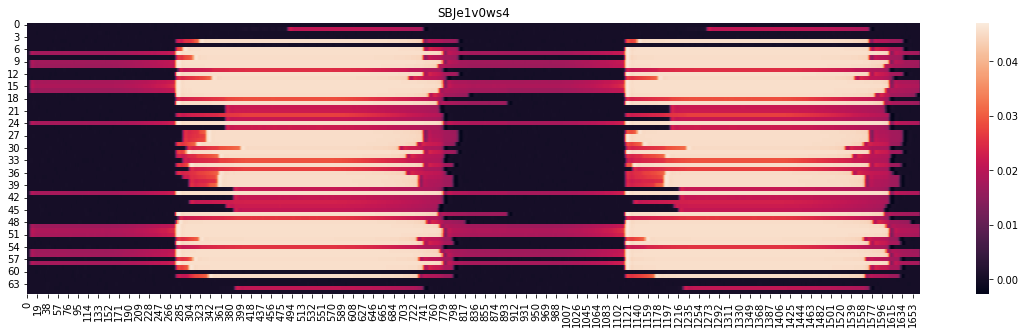

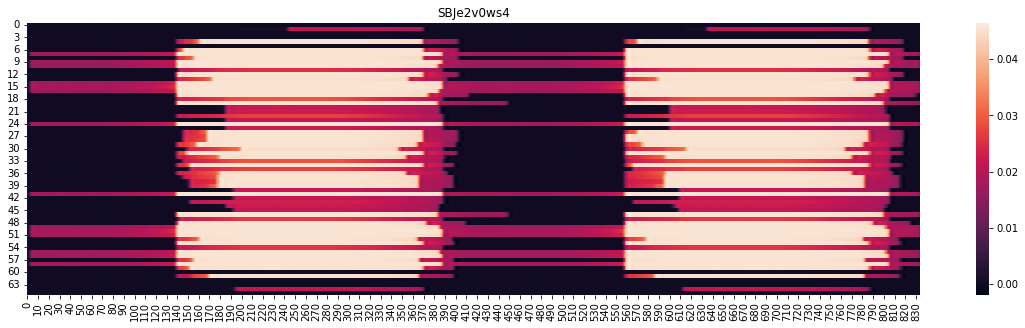

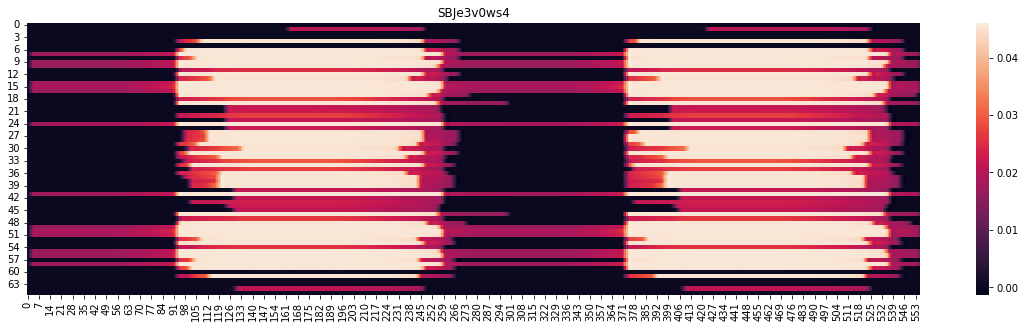

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
for sbj in list(subjects.keys()):
    new_bold = np.load(os.path.join(outpath, '{}_bold.npy'.format(sbj)))

    plt.figure(figsize=(20, 5))
    sns.heatmap(new_bold.T)
    plt.title(sbj)
    plt.show()

Write cohort file

In [6]:
cohort_path = os.path.join(outpath, 'cohort.csv')

cohort_header = ['id0', 'id1', 'id2', 'path', 'TR', 'task_path_G']

with open(cohort_path, 'w') as out:
    writer = csv.writer(out)
    writer.writerow(cohort_header)
    for sbjname, taskpath in subjects.items():
        writer.writerow([sbjname, '', '', '{}_bold.npy'.format(sbjname), trs[sbjname], os.path.join(outpath, taskpath)])


# Add noise to the subjects

In [7]:
outpath = os.path.join(os.environ['WORKSPACE'], 'data/w3c_wnoise2')
bold.shape

(1667, 66)

Generate noise using fmrisim package

In [ ]:
from brainiak.utils import fmrisim

bold2 = bold.T.reshape([66, 1, 1, 1667])
dim = bold2.shape
m = np.ones(dim[:3])

noise_dict = {'voxel_size': [66, 1, 1], 'matched': 1}
noise_dict = fmrisim.calc_noise(
    volume=bold2,
    mask=m,
    template=m,
    noise_dict=noise_dict)

tr = 0.72
for i in range(3): # This might take a while
    noise = fmrisim.generate_noise(
        dimensions=dim[0:3],
        tr_duration=int(tr),
        stimfunction_tr=[0] * dim[3], 
        mask=m,
        template=m,
        noise_dict=noise_dict,)
    noise = noise[:, 0, 0, :] # shape (66, 1667)
    np.save(os.path.join(outpath, f'noisebold{i}.npy'), noise)

The above brainiak script might take a while to generate. Instead, we use the previously generate noise from other runs

In [8]:
noisebold1 = np.load(os.path.join(outpath, 'noisebold1.npy')).T
noisebold2 = np.load(os.path.join(outpath, 'noisebold2.npy')).T
noisebold3 = np.load(os.path.join(outpath, 'noisebold3.npy')).T

"Shapes:"
for b in [bold, noisebold1, noisebold2, noisebold3]:
    print(b.shape)

In [10]:
import math
import random

def shuffle_parcels(mat):
    parcels_indices = list(range(mat.shape[1]))
    random.shuffle(parcels_indices)
    return mat[:, parcels_indices]

def add_prefix_zeros(s, cnt):
    assert len(s) <= cnt
    if len(s) == cnt:
        return s
    return '0' * (cnt - len(s)) + s

In [13]:
noise_all = np.concatenate([noisebold1, noisebold2, noisebold3], axis=1)
mean_std_signal = np.mean(np.std(bold, axis=0))
mean_std_noise = np.mean(np.std(noise_all, axis=0))
noise_all = noise_all * mean_std_signal / mean_std_noise

SNRs = [10.0, 5.0, 3.3, 2.5, 2.0, 1.3, 1.0, 0.8, 0.6, 0.5]
# simulated after percentages for the percentage to be the amount of
# noise std added to the BOLD signal

signal_mean = np.mean(bold)
std_noise = np.std(noise_all)

n_parcels = bold.shape[1]
subjects = []
for snr in SNRs:
    name = 'SBJ-SNR' + add_prefix_zeros(str(snr), 4)
    noise_sampled = shuffle_parcels(noise_all)
    noise_sampled = noise_sampled * signal_mean / snr / std_noise
    bold_wnoise = bold + noise_sampled[:, 0:n_parcels]
    bold_wnoise = shuffle_parcels(bold_wnoise)
    np.save(os.path.join(outpath, '{}.npy'.format(name)), bold_wnoise)
    subjects.append(name)


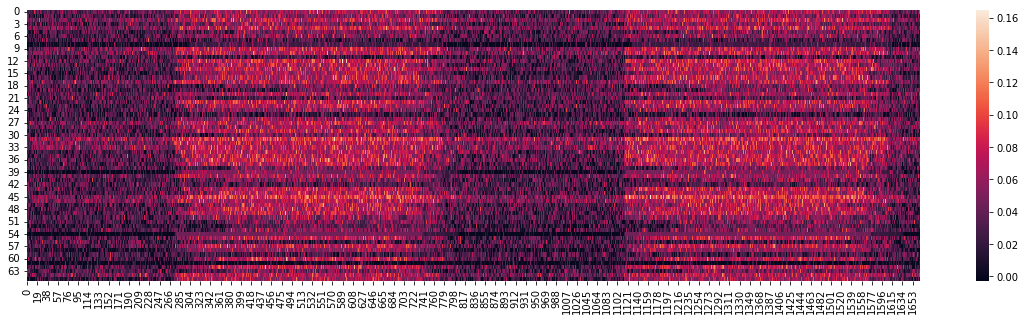

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

bold_wnoise = np.load(os.path.join(outpath, 'SBJ-SNR01.0.npy'))

plt.figure(figsize=(20, 5))
sns.heatmap(bold_wnoise.T)
plt.show()

Write cohort path

In [14]:
header = ['id0','id1','id2','path','TR']
with open(os.path.join(outpath, 'cohort.csv'), 'w') as out:
    writer = csv.writer(out)
    writer.writerow(header)
    for name in subjects:
        writer.writerow([name,'','','{}.npy'.format(name),0.72])

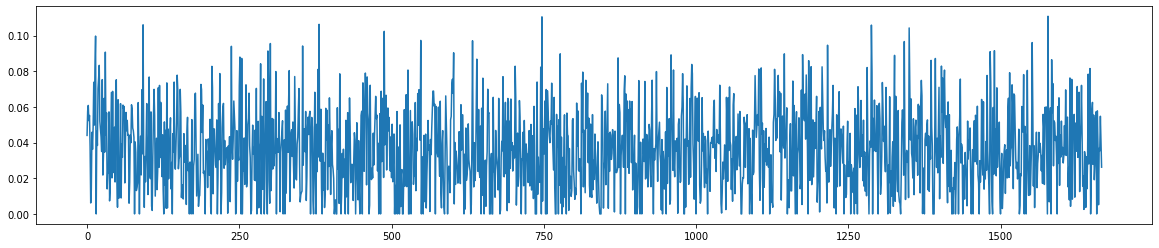

In [23]:
plt.figure(figsize=(20,4))
plt.plot(noisebold2[:, 7])
plt.show()